# A Simple Neural network
## Part 2: Logistic regression (classification)

This tutorial is part 2 of the [previous tutorial on neural networks](http://peterroelants.github.io/posts/2015/05/18/Simple_neural_network_part01/). While the previous tutorial described a very simple one-input-one-output linear regression model, this tutorial will describe a 2-class classification neural network with two input dimensions. This model is known in statistics as the [logistic regression](http://en.wikipedia.org/wiki/Logistic_regression) model.

![Image of the logistic model](https://dl.dropboxusercontent.com/u/8938051/Blog_images/SimpleANN02.png)

In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
np.seterr(all='ignore') # ignore numpy warning like multiplication of inf
import matplotlib.pyplot as plt  # Plotting library
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)

## Define the class distributions

In this example the target classes $t$ will be generated from 2 class distributions: blue ($t=1$) and red ($t=0$). Samples from both classes are sampled from their respective distributions. These samples are plotted in the figure below.


In [2]:
# Define and generate the samples
nb_of_samples_per_class = 20  # The number of sample in each class
red_mean = [-1,0]  # The mean of the red class
blue_mean = [1,0]  # The mean of the blue class
std_dev = 1.2  # standard deviation of both classes
# Generate samples from both classes
x_red = np.random.randn(nb_of_samples_per_class, 2) * std_dev + red_mean
x_blue = np.random.randn(nb_of_samples_per_class, 2) * std_dev + blue_mean

# Merge samples in set of input variables x, and corresponding set of
# output variables t
x = np.vstack((x_red, x_blue))
t = np.vstack((np.zeros((nb_of_samples_per_class,1)), np.ones((nb_of_samples_per_class,1))))

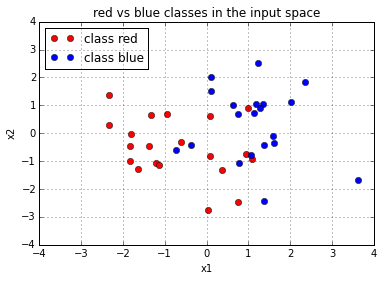

In [3]:
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis([-4, 4, -4, 4])
plt.title('red vs blue classes in the input space')
plt.show()

## Logistic function

The goal is to predict the target class $t$ from the input values $x$. The network is defined as having an input $x = [x_1, x_2]$ which gets transformed by the weights $w = [w_1, w_2]$ to generate the probability that sample $x$ belongs to class $t=1$. This probability $P(t=1| x,w)$ is represented by the output $y$ of the network computed as $y = \sigma(x * w^T)$. $\sigma$ is the [logistic function](http://en.wikipedia.org/wiki/Logistic_function) and is defined as:
$$ \sigma(z) = \frac{1}{1+e^{-z}} $$

This logistic function maps the input $z$ to an output between $0$ and $1$ as is illustrated in the figure below.

We can write the probabilities that the class is $t=1$ or $t=0$ given input $x$ as:

$$ P(t=1| x) = \sigma(x * w^T) = \frac{1}{1+e^{-x * w^T}} $$
$$ P(t=0| x) = 1 - \sigma(x * w^T) = \frac{e^{-x * w^T}}{1+e^{-x * w^T}} $$

Note that the logistic function is derived from the log [odds ratio](http://www.ats.ucla.edu/stat/mult_pkg/faq/general/odds_ratio.htm) of $P(t=1|x)$ over $P(t=0|x)$.

$$\begin{split}
log \frac{P(t=1|x)}{P(t=0|x)} & = log \frac{\frac{1}{1+e^{-x * w^T}}}{\frac{e^{-x * w^T}}{1+e^{-x * w^T}}} = log \frac{1}{e^{-x * w^T}} \\
& = log(1) - log(e^{-x * w^T}) = x * w^T
\end{split}$$

This means that the logg odds ratio $log(P(t=1|x)/P(t=0|x))$ changes linearly with the parameters $w$.

In [4]:
# Define the logistic function
def logistic(z): return 1 / (1 + np.exp(-z))

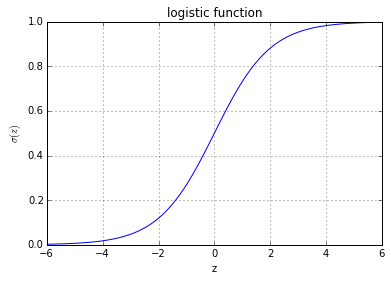

In [5]:
# Plot the logistic function
z = np.linspace(-6,6,100)
plt.plot(z, logistic(z), 'b-')
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.title('logistic function')
plt.grid()
plt.show()

## Define the cost function

As written before the output of the model $y = \sigma(x * w^T)$ can be interpreted as a probability $y$ that sample $x$ belongs to one class $(t=1)$, or probability $1-y$ that $x$ belongs to the other class $(t=0)$ in a two class classification problem. We note this down as: $P(t=1| x; w) = \sigma(x * w^T) = y$.

This model will be optimized by maximizing the [likelihood](http://en.wikipedia.org/wiki/Likelihood_function) that a given set of parameters $w$ can predict the correct class given an input set $x$ of size $n$, and corresponding labels $t$:

$$\underset{w}{\text{argmax}}\; \mathcal{L}(w|t,x) = \underset{w}{\text{argmax}} \prod_{i=1}^{n} \mathcal{L}(w|t_i,x_i)$$

We can rewrite the likelihood $\mathcal{L}(w|t,x)$ as the [joint probability](http://en.wikipedia.org/wiki/Joint_probability_distribution) of generating $t$ and $x$ given the parameters $w$: $P(t,x|w)$. Since $P(A,B) = P(A|B)*P(B)$ this can be written as:

$$P(t,x|w) = P(t|x;w)P(x|w)$$

Since we are not interested in the probability of $x$, and $x$ is independent of $w$ we can reduce this to: $\mathcal{L}(w|t,x) = P(t|x;w) = \prod_{i=1}^{n} P(t_i|x_i;w)$. 
Since $t_i$ is a [Bernoulli variable](http://en.wikipedia.org/wiki/Bernoulli_distribution) we can rewrite this as: 

$$\begin{split}
P(t|x;w) & = \prod_{i=1}^{n} P(t_i=1|x_i;w)^{t_i} * (1 - P(t_i=1|x_i;w))^{1-t_i} \\
& = \prod_{i=1}^{n} y_i^{t_i} * (1 - y_i)^{1-t_i} \end{split}$$

Since the logartimic function is a monotone increasing function we can optimize the log-likelihood function $\underset{w}{\text{argmax}}\; log \mathcal{L}(w|t,x)$. This maximum will be the same as the maximum from the regular likelihood function. The log-likelihood function can be written as:

$$\begin{split} log \mathcal{L}(w|t,x) & = log \prod_{i=1}^{n} y_i^{t_i} * (1 - y_i)^{1-t_i} \\
& = \sum_{i=1}^{n} t_i log(y_i) + (1-t_i) log(1 - y_i)
\end{split}$$

Minimizing the negative of this function (minimizing the negative log likelihood) corresponds to maximizing the likelihood. This error function $\xi(t,y)$ is typically known as the [cross-entropy error function](http://en.wikipedia.org/wiki/Cross_entropy) (also known as log-loss):

$$\begin{split}
\xi(t,y) & = - log \mathcal{L}(w|t,x) \\
& = - \sum_{i=1}^{n} \left[ t_i log(y_i) + (1-t_i)log(1-y_i) \right] \\
& = - \sum_{i=1}^{n} \left[ t_i log(\sigma((x_i * w) + b)) + (1-t_i)log(1-\sigma((x_i * w) + b)) \right]
\end{split}$$

This function looks complicated but besided the previous derivation there are a couple of intuitions why this function is used as a cost function for logistic regression. First of all it can be rewritten as:

$$ \xi(t_i,y_i) = 
   \begin{cases}
   -log(y_i) & \text{if } t_i = 1 \\
   -log(1-y_i) & \text{if } t_i = 0
  \end{cases}$$
  
Which in the case of $t_i=1$ is $0$ if $y_i=1$ $(-log(1)=0)$ and goes to infinity as $y_i \rightarrow 0$ $(\underset{y \rightarrow 0}{\text{lim}}  -log(y) = +\infty)$. The reverse effect is happening if $t_i=0$.  
So what we end up with is a cost function that is $0$ if the probability to predict the correct class is $1$, and goes to infinity as the probability to predict the correct class goes to $0$.

Notice that the cost function $\xi(t_i,y_i)$ is equal to the negative [log probability](http://en.wikipedia.org/wiki/Log_probability) that $x_i$ is classified as its correct class:  
$-log(P(t_i=1| x_i,w,b)) = -log(y_i)$,  
$-log(P(t_i=0| x_i,w,b)) =$ $-log(1-y_i)$.

By minimizing the negative log probability we will maximize the log probability.

Note that since $t_i$ can only be $0$ or $1$, we can write $\xi(t_i,y_i)$ as:
$$ \xi(t_i,y_i) = -t_i log(y_i) - (1-t_i)log(1-y_i) $$

Which will give $\xi(t,y) = - \sum_{i=1}^{n} \left[ t_i log(y_i) + (1-t_i)log(1-y_i) \right]$ if we sum over all $n$ samples.



Another reason to use the cross-entropy function is that in simple logistic regression this results in a [convex](http://en.wikipedia.org/wiki/Convex_function) cost function, of which the global minimum will be easy to find. Note that this is not necessaraly the case anymore in multilayer neural networks. The plane of the cost function resulting from the samples is shown in the figure below.

In [6]:
# Define the neural network function y = 1 / (1 + numpy.exp(-x*w))
def nn(x, w): return logistic(x.dot(w.T))

# Define the neural network prediction function that only returns
#  1 or 0 depending on the predicted class
def nn_predict(x,w): return np.around(nn(x,w))
    
# Define the cost function
def cost(y, t):
    return - np.sum(np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

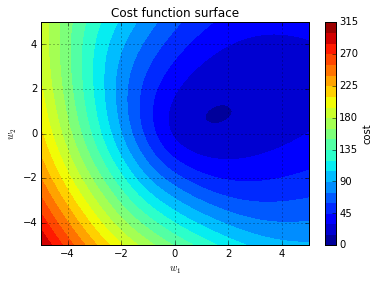

In [7]:
# Plot the cost in function of the weights
# Define a vector of weights for which we want to plot the cost
nb_of_ws = 100 # compute the cost nb_of_ws times in each dimension
ws1 = np.linspace(-5, 5, num=nb_of_ws) # weight 1
ws2 = np.linspace(-5, 5, num=nb_of_ws) # weight 2
ws_x, ws_y = np.meshgrid(ws1, ws2) # generate grid
cost_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize cost matrix
# Fill the cost matrix for each combination of weights
for i in xrange(nb_of_ws):
    for j in xrange(nb_of_ws):
        cost_ws[i,j] = cost(nn(x, np.asmatrix([ws_x[i,j], ws_y[i,j]])) , t)
# Plot the cost function surface
plt.contourf(ws_x, ws_y, cost_ws, 20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('cost')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Cost function surface')
plt.grid()
plt.show()

## Gradient descent optimization of the cost function

The [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) algorithm works by taking the [derivative](http://en.wikipedia.org/wiki/Derivative) of the cost function $\xi$ with respect to the parameters, and updates the parameters in the direction of the negative [gradient](http://en.wikipedia.org/wiki/Gradient).

The parameters $w$ are updated by taking steps proportional to the negative of the gradient: $w(k+1) = w(k) - \Delta w(k+1)$. $\Delta w$ is defined as: $\Delta w = \mu \frac{\partial \xi}{\partial w}$ with $\mu$ the learning rate.

We will compute ${\partial \xi}/{\partial w}$, as follows:

$$\frac{\partial \xi}{\partial w} = \frac{\partial z}{\partial w} \frac{\partial y}{\partial z} \frac{\partial \xi}{\partial y}$$

Where $y = \sigma(z)$ is the output of the logistic neuron, and $z = x * w^T$ the input to the logistic neuron. 

* ${\partial \xi}/{\partial y}$ can be calculated as:

$$\begin{split}
\frac{\partial \xi}{\partial y} & = \frac{\partial (-t log(y) - (1-t)log(1-y))}{\partial y} = \frac{\partial (-t log(y))}{\partial y} +  \frac{\partial (- (1-t)log(1-y))}{\partial y} \\
& = -\frac{t}{y} + \frac{1-t}{1-y} = \frac{y-t}{y(1-y)}
\end{split}$$


* ${\partial y}/{\partial z}$ can be calculated as:

$$\frac{\partial y}{\partial z} = \frac{\partial \sigma(z)}{\partial z} = \frac{\partial \frac{1}{1+e^{-z}}}{\partial z} = \frac{e^{-z}}{(1+e^{-z})^2} = \frac{1}{1+e^{-z}} \frac{e^{-z}}{1+e^{-z}}$$

And since $1 - \sigma(z)) = 1 - {1}/(1+e^{-z}) = {e^{-z}}/(1+e^{-z})$ this can be rewritten as:

$$\frac{\partial y}{\partial z} = \frac{1}{1+e^{-z}} \frac{e^{-z}}{1+e^{-z}} = \sigma(z) * (1- \sigma(z)) =  y (1-y)$$

* ${\partial z}/{\partial w}$ can be calculated as:

$$\frac{\partial z}{\partial w} = \frac{\partial (x * w)}{\partial w} = x $$

Bringing this together we can write:

$$\frac{\partial \xi}{\partial w} = \frac{\partial z}{\partial w} \frac{\partial y}{\partial z} \frac{\partial \xi}{\partial y} = x * y (1-y) * \frac{y-t}{y(1-y)} = x * (y-t) $$

Notice how this gradient is the same (negating the constant factor) as the gradient of the squared error regression.

So the full update function $\Delta w_j$ for each weight will become

$$\Delta w_j = \mu * \frac{\partial \xi}{\partial w_j} = \mu * x_j * (y-t)$$

In the batch processing, we just add up all the gradients for each sample:

$$\Delta w_j = \mu * \sum_{i=1}^{n} x_{ij} (y_i - t_i)$$

To start out the gradient descent algorithm, you typically start with picking the initial parameters at random and start updating these parameters according to the delta rule with $\Delta w$ until convergence.

In [8]:
# define the gradient function.
def gradient(w, x, t): return (nn(x, w) - t).T * x

# define the update function delta w which returns the 
#  delta w for each weight in a vector
def delta_w(w_k, x, t, learning_rate):
    return learning_rate * gradient(w_k, x, t)

### Gradient descent updates

An example run of gradient descent on the example inputs $x$ and targets $t$ is shown in the figure below. The black dots represent the weight parameter values $w(k)$ at iteration $k$.

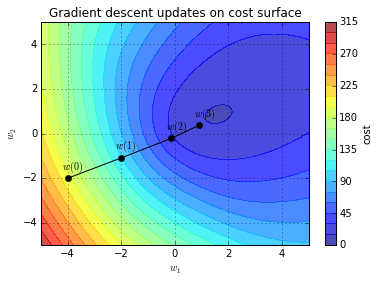

In [9]:
# Set the initial weight parameter
w = np.asmatrix([-4, -2])
# Set the learning rate
learning_rate = 0.05

# Plot the error surface
plt.contourf(ws_x, ws_y, cost_ws, 20, alpha=0.7)
cbar = plt.colorbar()
cbar.ax.set_ylabel('cost')

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 3  # number of gradient descent updates
for i in xrange(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)  # get the delta w update
    # Plot the weight-cost value and the line that represents the update
    plt.plot(w[0,0], w[0,1], 'ko')  # Plot the weight cost value
    w_new = w-dw # update the weights
    plt.plot([w[0,0], w_new[0,0]], [w[0,1], w_new[0,1]], 'k-')
    plt.text(w[0,0]-0.2, w[0,1]+0.4, '$w({})$'.format(i))
    w = w_new  # set the weight to the updated weights
    
# Plot the last weight, axis, and show figure
plt.plot(w[0,0], w[0,1], 'ko')
plt.text(w[0,0]-0.2, w[0,1]+0.4, '$w({})$'.format(nb_of_iterations))  
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Gradient descent updates on cost surface')
plt.grid()
plt.show()

The resulting decision boundary of running gradient descent on the example inputs $x$ and targets $t$ is shown in the figure below. The background color refers to the classification decision of the trained classifier. Note that since this decision plane is linear that not all examples can be classified correctly. Two blue dots will be misclassified as red, and four red spots will be misclassified as blue.

Not that the decision boundary goes through the point $(0,0)$ since we don't have a bias parameter on the logistic output unit.

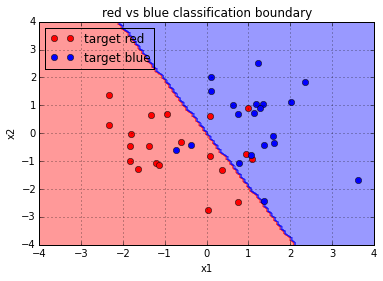

In [10]:
# Set the initial weight parameter
w = np.asmatrix([-4, -2])
# Set the learning rate
learning_rate = 0.05

# Start performing the gradient descent updates, and print the weights and cost:
nb_of_iterations = 10  # number of gradient descent updates
for i in xrange(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)  # get the delta w update
    w = w - dw  # update the current weight parameter

    
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 100
xs1 = np.linspace(-4, 4, num=nb_of_xs)
xs2 = np.linspace(-4, 4, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in xrange(nb_of_xs):
    for j in xrange(nb_of_xs):
        classification_plane[i,j] = nn_predict(np.asmatrix([xx[i,j], yy[i,j]]) , w)
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.40),
        colorConverter.to_rgba('b', alpha=0.40)])

# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='target red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='target blue')
plt.grid()
plt.legend(loc=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('red vs blue classification boundary')
plt.show()